In [52]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import statistics

from astroquery.gaia import Gaia

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'


In [109]:
# query = """SELECT 
# TOP 5000000
# source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
# FROM gaiadr2.gaia_source
# WHERE parallax_over_error > 10
# AND phot_g_mean_flux_over_error>50
# AND phot_rp_mean_flux_over_error>20
# AND phot_bp_mean_flux_over_error>20
# AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# AND visibility_periods_used>8
# AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
# AND 1000/parallax <=200
# """

query =  """SELECT 
TOP 300000
source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
FROM gaiadr2.gaia_source
where parallax_over_error > 10
and visibility_periods_used > 8
and phot_g_mean_flux_over_error > 50
and phot_bp_mean_flux_over_error > 20
and phot_rp_mean_flux_over_error > 20
and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
and phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
and 1000/parallax <= 200
"""

job = Gaia.launch_job_async(query) #_async
r = job.get_results()
print(type(r))
df = r.to_pandas()
df.to_csv(f'{global_path}/gaiaplot6.csv', index=False)

INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


(20.0, -5.0)

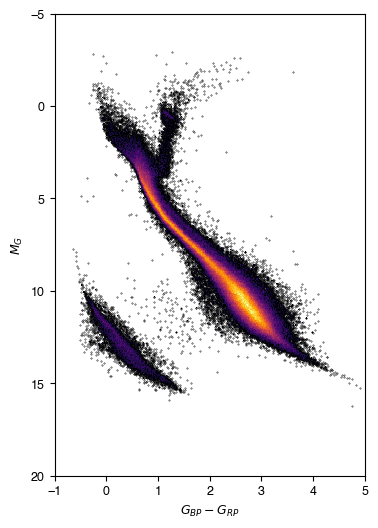

In [114]:
df = pd.read_csv(f'{global_path}/gaiaplot6.csv')
bp_rp = r['bp_rp'].data
mg = r['mg'].data
d = 1000/r['parallax'].data

    # d = r['distance'].data
# Teff = 8907.2 / (0.92 * (bp_rp) + 1.7)
# Lum = 10**(-(mg-4.83)/2.5) * (d/10)**2
# #https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html GAIAI citation
# #Casagrande et al. (2018) 
# https://vlas.dev/post/gaia-dr2-hrd/


# Plot the HR diagram
fig, ax = plt.subplots(figsize = (4,6))
h = ax.hist2d(bp_rp, mg, bins=300, cmin=2, norm=colors.PowerNorm(0.5), zorder=0.5,cmap = 'inferno')
ax.scatter(bp_rp, mg, s=0.1, color='black', zorder=0)
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-1, 5)
ax.set_ylim(20, -5)

AttributeError: 'Axes' object has no attribute 'secondary_axis'

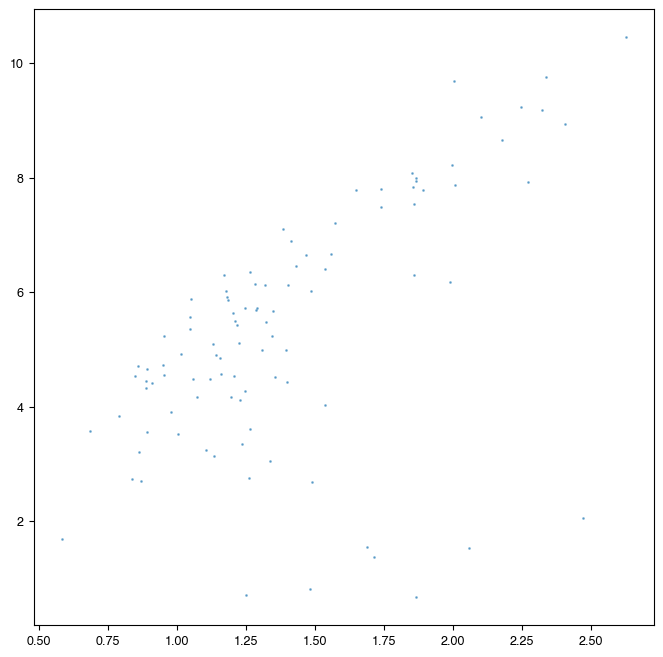

In [26]:
# Your existing code to plot the HR diagram
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(bp_rp, mg, s=1, alpha=0.5, edgecolors=None)
# Plot the transformed data on the new axis
ax2 = ax.secondary_axis('right', functions=(lambda x: x, lambda x: x))
ax2.set_ylabel('Effective Temperature (K)')

# Plot the transformed data on the new axis
ax2 = ax.secondary_axis('right', functions=(lambda x: x, lambda x: x))
ax2.set_ylabel('Effective Temperature (K)')

ax2.scatter(L, T_eff, s=1, alpha=0.5, edgecolors=None)

# Set the limits of the new axis to match the limits of the HR diagram
ax2.set_ylim(ax.get_ylim())

# Add a label to the new axis
ax2.yaxis.set_label_position('right')
ax2.yaxis.label.set_color('C1')
ax2.tick_params(axis='y', colors='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_visible(False)

In [ ]:
def send_radial_gaia_query(query_size=1000, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("SELECT TOP {}".format(query_size)+
        "source_id, ra, dec, radial_velocity, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg, 1000/parallax AS distance" 
        "FROM gaiadr2.gaia_source"
        "WHERE parallax_over_error > 10"
        "AND phot_g_mean_flux_over_error>50"
        "AND phot_rp_mean_flux_over_error>20"
        "AND phot_bp_mean_flux_over_error>20"
        "AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
        "AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
        "AND visibility_periods_used>8"
        "AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))")

    return job

try:
    gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
    bp_rp, mg = gaiarec.bp_rp, gaiarec.mg#, gaiarec.distance
except OSError:
    job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                    output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
                                    query_size=10)
    r = job.get_results()
    bp_rp = r['bp_rp'].data
    mg = r['mg'].data
    # d = r['distance'].data
d = 200 * len(mg)
# Teff = 8907.2 / (0.92 * (bp_rp) + 1.7)
# Lum = 10**(-(mg-4.83)/2.5) * (d/10)**2
#https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html GAIAI citation
#Casagrande et al. (2018)

# Define function to convert absolute magnitude to luminosity
def abs_mag_to_luminosity(abs_mag, distance):
    M_sun = 4.83
    L_sun = 3.828e26 # in Watts
    return L_sun * 10**(-0.4*(abs_mag - M_sun)) / (4 * np.pi * (distance * 3.086e+16)**2)

# Define function to convert bp-rp to effective temperature
def bp_rp_to_Teff(bp_rp):
    a = 3.939
    b = 0.6528
    c = 0.0603
    return 4600 * np.power(1/(a + b*np.log10(bp_rp) + c*np.power(np.log10(bp_rp), 3)), 1/2)
def Teff_to_bp_rp(Teff):
    a = 3.939
    b = 0.6528
    c = 0.0603
    return np.power(10, (a - np.log10(Teff/4600)) / b + c*np.log10(Teff/4600))


# Convert absolute magnitude to luminosity
L = abs_mag_to_luminosity(mg, d)
# Convert bp-rp to effective temperature
Teff = bp_rp_to_Teff(bp_rp)

# Plot the HR diagram
fig, ax = plt.subplots()
ax.scatter(bp_rp, mg, s=0.1, color='black')
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-0.5, 4)
ax.set_ylim(15, -5)

# Set the limits and ticks for the new axis
axT = ax.twiny()
bp_rp_min, bp_rp_max = axT.get_xlim()
axT.set_xlim(bp_rp_to_Teff(bp_rp_min), bp_rp_to_Teff(bp_rp_max))
Teff_ticks = np.array([3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000])
bp_rp_ticks = Teff_to_bp_rp(Teff_ticks)
axT.set_xticks(bp_rp_ticks)
axT.set_xticklabels(Teff_ticks)

# Set the label for the new axis
axT.set_xlabel('Effective Temperature (K)', fontsize=12)

# Add gridlines for the new axis
axT.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# # Define the secondary axis for luminosity
# def luminosity_to_abs_mag(luminosity, distance):
#     M_sun = 4.83
#     L_sun = 3.828e26 # in Watts
#     return M_sun - 2.5*np.log10(luminosity/(L_sun/(4*np.pi*(distance*3.086e+16)**2)))

# def luminosity_formatter(x, pos):
#     abs_mag = luminosity_to_abs_mag(x, d)
#     return f'{x:.1e}\nM/Msun\n(M_G={abs_mag:.2f})'

# ax.secondary_yaxis('right', functions=(luminosity_to_abs_mag, luminosity_formatter))
# ax.set_ylim(ax.get_ylim()[::-1]) # flip the y-axis

# # Define the tertiary axis for Teff
# def Teff_to_bp_rp(Teff):
#     a = 3.939
#     b = 0.6528
#     c = 0.0603
#     x = np.power((4600/Teff),2) - a
#     y = b*np.log10(bp_rp) + c*np.power(np.log10(bp_rp), 3)
#     return np.power(x/y,1/2)

# def Teff_formatter(x, pos):
#     return f'{x:.0f}\nK'

# ax.secondary_xaxis('top', functions=(Teff_to_bp_rp, Teff_formatter))

$\tau$ Bins


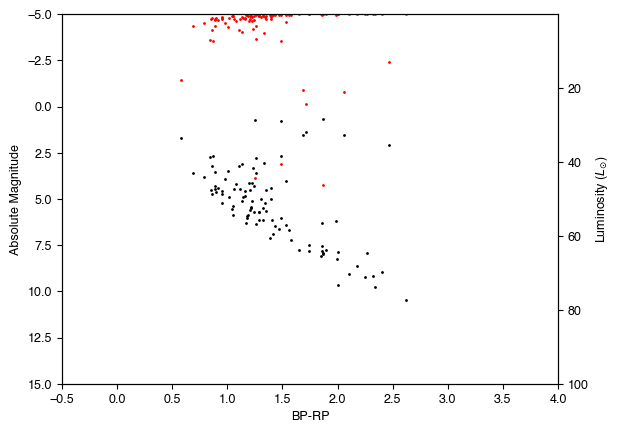

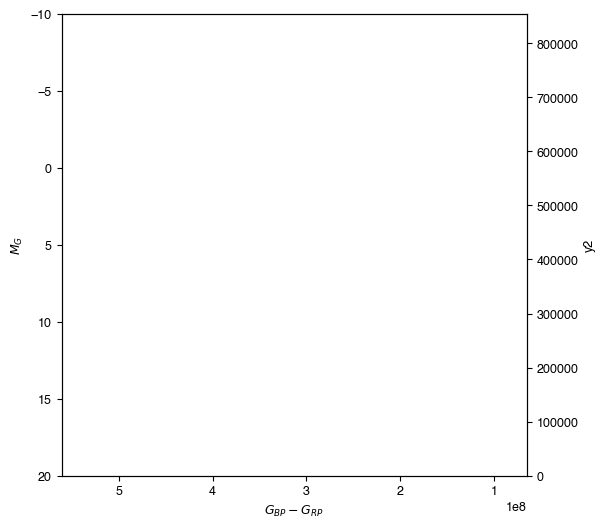

In [25]:
# Define Font Settings
plt.rcParams.update({'font.size': 9})
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.family'] = 'sans-serif'
print(r'$\tau$ Bins')

# Plot the HR diagram
fig, ax1 = plt.subplots()
ax1.plot(bp_rp, mg, 'o', markersize=1, color='black')
ax1.set_xlim(-0.5, 4)
ax1.set_ylim(15, -5)
# ax1.set_xlim(-1,5)
# ax1.set_ylim(20,-10)
ax1.set_xlabel('BP-RP')
ax1.set_ylabel('Absolute Magnitude')

# Add the second axis for luminosity
ax2 = ax1.twinx()
ax2.plot(bp_rp, L, 'o', markersize=1, color='red')
ax2.set_ylim(100, 0.001)
ax2.set_ylabel('Luminosity ($L_{\odot}$)')



fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
# h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.5, s=10, color='k', zorder=0)
ax.invert_yaxis()
# cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r"$G_{BP} - G_{RP}$")
ax.set_ylabel(r"$M_G$")
ax.set_xlim(-1,5)
ax.set_ylim(20,-10)

# Create the second axis and plot y2
ax2 = ax.twinx()
ax2.set_ylabel('y2')
ax2.set_ylabel('y2')

# Set the limits of the second axis based on the limits of the first axis
y1_min, y1_max = ax.get_ylim()
y2_min = 10**((4.83 - y1_min)/2.5)
y2_max = 10**((4.83 - y1_max)/2.5)
x1_min, x1_max = ax.get_ylim()
x2_min = (4370 * x1_min ** 4) - (18620 * x1_min ** 3) + (27834 * x1_min ** 2) - (16172 * x1_min) + 3251.4
x2_max = (4370 * x1_max ** 4) - (18620 * x1_max ** 3) + (27834 * x1_max ** 2) - (16172 * x1_max) + 3251.4
ax2.set_ylim(y2_min, y2_max)
ax2.set_xlim(x2_min, x2_max)
# cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()


In [ ]:
# def send_radial_gaia_query(query_size=1000, **kwargs):
#     """
#     Sends an archive query for d < 200 pc, with additional filters taken from
#     Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
#     Gaia Collaboration, Babusiaux et al. (2018)
#     (https://doi.org/10.1051/0004-6361/201832843)

#     NOTE: 10000000 is a maximum query size (~76 MB / column)

#     Additional keyword arguments are passed to TapPlus.launch_job_async method.
#     """

#     job = Gaia.launch_job("SELECT TOP {}".format(query_size)+
#         "source_id, ra, dec, radial_velocity, bp_rp, parallax, phot_g_mean_mag+5*log10(parallax)-10 AS mg" 
#         "FROM gaiadr2.gaia_source"
#         "WHERE parallax_over_error > 10"
#         "AND phot_g_mean_flux_over_error>50"
#         "AND phot_rp_mean_flux_over_error>20"
#         "AND phot_bp_mean_flux_over_error>20"
#         "AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
#         "AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
#         "AND visibility_periods_used>8"
#         "AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))")

#     return job

# try:
#     gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
#     bp_rp, mg, par = gaiarec.bp_rp, gaiarec.mg, gaiarec.parallax
#     d = 1000/par
# except OSError:
#     job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
#                                     output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
#                                     query_size=1000)
#     r = job.get_results()
#     bp_rp = r['bp_rp'].data
#     mg = r['mg'].data
#     par = r['parallax'].data
#     d = 1000/par

In [19]:
def send_radial_gaia_query(query_size=100, distance=200, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("select top {}".format(query_size)+
                #" lum_val, teff_val,"
                #" ra, dec, parallax,"
                " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg"
         " from gaiadr2.gaia_source"
         " where parallax_over_error > 10"
         " and visibility_periods_used > 8"
         " and phot_g_mean_flux_over_error > 50"
         " and phot_bp_mean_flux_over_error > 20"
         " and phot_rp_mean_flux_over_error > 20"
         " and phot_bp_rp_excess_factor <"
            " 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and phot_bp_rp_excess_factor >"
            " 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
            "1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
         +" and 1000/parallax <= {}".format(distance), **kwargs)

    return job

try:
    gaiarec = np.recfromcsv(f'{global_path}/gaia-hrd-dr2-200pc.csv')
    bp_rp, mg = gaiarec.bp_rp, gaiarec.mg
except OSError:
   job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                 output_file=f'{global_path}/gaia-hrd-dr2-200pc.csv',
                                 query_size=100)
r = job.get_results()
bp_rp = r['bp_rp'].data
mg = r['mg'].data

HTTPError: Moved Temporarily

In [ ]:
# plot the H-R diagram for 1 M stars within 200 pc from the Sun
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()

In [68]:
#https://datacarpentry.org/astronomy-python/aio/index.html
tables = Gaia.load_tables(only_names=True)
# for table in tables:
#     print(table.name)
table_metadata = Gaia.load_table('gaiadr2.gaia_source')
print(table_metadata)
# for column in table_metadata.columns:
#     print(column.name)
panstarrs_metadata = Gaia.load_table('gaiadr2.panstarrs1_original_valid')
print(panstarrs_metadata)
query1 = """SELECT 
TOP 2000
source_id, ra, dec, radial_velocity, bp_rp, parallax
FROM gaiadr2.gaia_source
"""
job1 = Gaia.launch_job(query1)
job1
results1 = job1.get_results()
type(results1)
results1
from astropy.table import Table




INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
Retrieving table 'gaiadr2.gaia_source'
TAP Table name: gaiadr2.gaiadr2.gaia_source
Description: This table has an entry for every Gaia observed source as listed in the
Main Database accumulating catalogue version from which the catalogue
release has been generated. It contains the basic source parameters,
that is only final data (no epoch data) and no spectra (neither final
nor epoch).
Num. columns: 95
Retrieving table 'gaiadr2.panstarrs1_original_valid'
TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 surve